# Drizzle 1: drizzle setup

Exercise the drizzle core algorithm to find the correct parameters to use in this project.

For now, we pay no attention to the fact the images are RGB Bayer-coded. All pixels are treated equally. A subsequent notebook will handle the gory details of 3-color drizzling.

In [1]:
# %matplotlib notebook

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from drizzle import cdrizzle
import rawpy

from datapath import DATA

## Basic drizze call

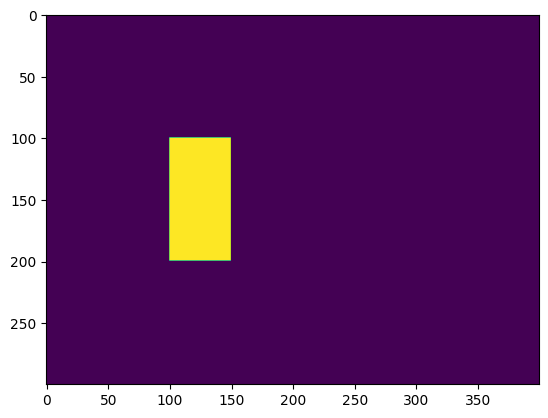

In [2]:
# simple test image - make it non-square so as to test the pixmap shaping algorithm
sizey = 300
sizex = 400
data = np.zeros((sizey, sizex), dtype='float32')
weights = np.ones((sizey, sizex), dtype='float32')

# image made of zeros, except for a rectangular area with ones
data[100:200, 100:150] = 1

# plt.imshow(data[90:110,90:110], vmin=0, vmax=1)
plt.imshow(data, vmin=0, vmax=1)

In [3]:
# pixmap is built following the "recipe" in the `drizzle.calc_pixmap` function
idxmap = np.indices((sizex, sizey), dtype='float64') # note the swapping of X and Y axis...

# move 100.3 in X and 50.5 in Y
idxmap[0] += 100.3 
idxmap[1] += 50.5 

idxmap = idxmap.transpose()
idxmap = idxmap.reshape(sizex * sizey, 2)
pixmap = idxmap.reshape(sizey, sizex, 2)

In [4]:
# allocate output arrays
output_data = np.zeros((sizey, sizex), dtype='float32')
output_counts = np.zeros((sizey,sizex), dtype='float32')
output_context = np.zeros((sizey, sizex), dtype='int32')

# call C core drizzle algorithm
cdrizzle.tdriz(data, weights, pixmap, output_data, output_counts, output_context)

('Callable C-based DRIZZLE Version 1.12 (28th June 2018)', 45000, 48)

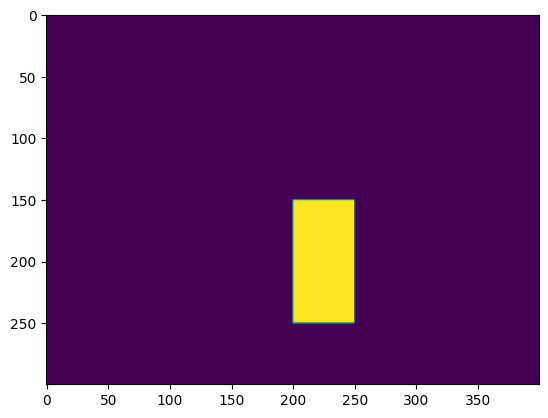

In [5]:
# plt.imshow(output_data[140:160,140:160], vmin=0, vmax=1)
plt.imshow(output_data, vmin=0, vmax=1)

The output array above shows fractional pixel coverage effects at the object edges, compatible with the offsets added to the pixmap.

## Apply drizzle to real image

In [6]:
# reference image used in the Offsets_X scripts. Offsets are defined against this image.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03770.ARW')
raw = rawpy.imread(fname)
reference_imarray = raw.raw_image_visible.astype(float)

In [7]:
# last image in sequence. This should have the largest offsets.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03829.ARW')
# fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03820.ARW')
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

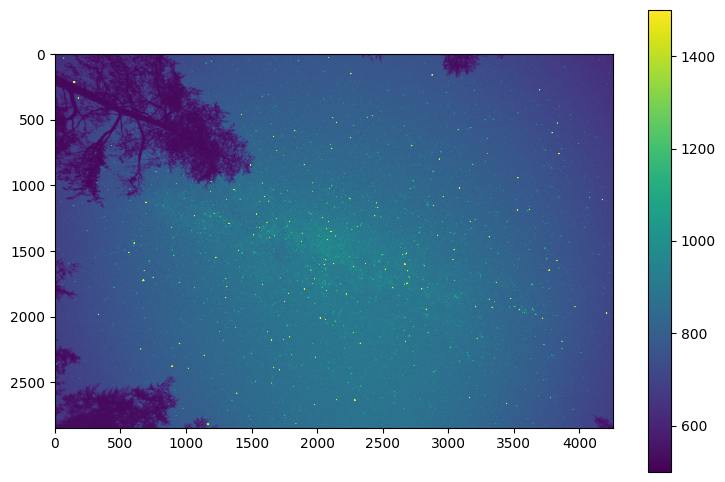

In [8]:
plt.figure(figsize=[9, 6])
plt.imshow(reference_imarray, vmin=500, vmax=1500)
plt.colorbar()

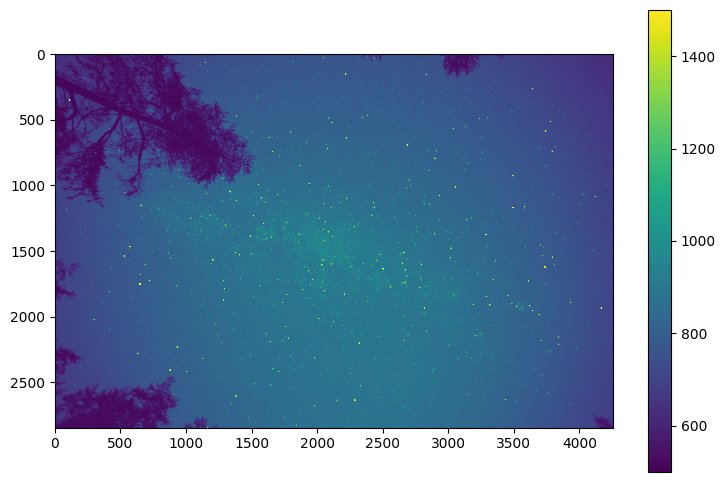

In [9]:
plt.figure(figsize=[9, 6])
plt.imshow(imarray, vmin=500, vmax=1500)
plt.colorbar()

In [10]:
# define slice for displaying a small subset of images.
aslice = np.index_exp[1100:1290,1900:2100]
# aslice = np.index_exp[1000:1500,800:1300]

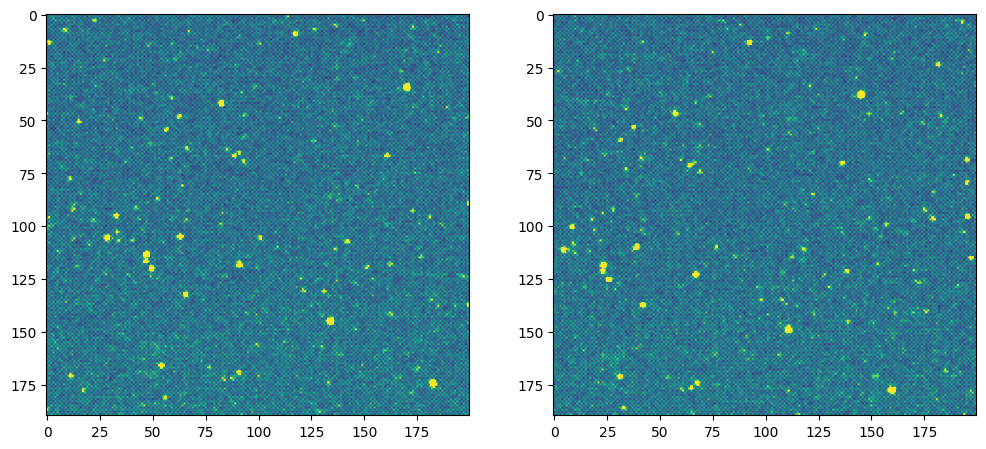

In [11]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(imarray[aslice], vmin=500, vmax=1500)

In [12]:
print(np.mean(reference_imarray[aslice]), np.std(reference_imarray[aslice]))
print(np.mean(imarray[aslice]), np.std(imarray[aslice]))

900.1594736842105 254.81773814514403
897.4373684210526 264.31687705921837


In [13]:
# pixel offsets come from matching offsets file built by Offsets_X set of scripts.
fname_offsets = fname.replace('ARW', 'offsets.fits')

f = fits.open(fname_offsets)
offsets_x = f[1].data
offsets_y = f[2].data
f.close()

In [14]:
# build pixmap with "map into itself" data
idxmap = np.indices((imarray.shape[1], imarray.shape[0]), dtype='float64')

# add offsets  
idxmap[0] -= offsets_x.transpose()
idxmap[1] -= offsets_y.transpose()

# reshape to format cdrizzle understands
idxmap = idxmap.transpose()
idxmap = idxmap.reshape(imarray.shape[1] * imarray.shape[0], 2)
pixmap = idxmap.reshape(imarray.shape[0], imarray.shape[1], 2)

# weigths and auxiliary output arrays (not used for now)
weights = np.ones(imarray.shape, dtype='float32')
output_counts = np.zeros(imarray.shape, dtype='float32')
output_context = np.zeros(imarray.shape, dtype='int32')

# main cdrizzle output array
output_data = np.zeros(imarray.shape, dtype='float32')

In [15]:
# we cannot use directly the array generated by rawpy, as input to cdrizzle (it barfs).
# Generate zeroed numpy array and add the rawpy array into it.
imarray_f = np.zeros(imarray.shape, dtype='float32')
imarray_f += imarray

In [16]:
# call C core drizzle algorithm
cdrizzle.tdriz(imarray_f, weights, pixmap, output_data, output_counts, output_context)

('Callable C-based DRIZZLE Version 1.12 (28th June 2018)', 180326, 0)

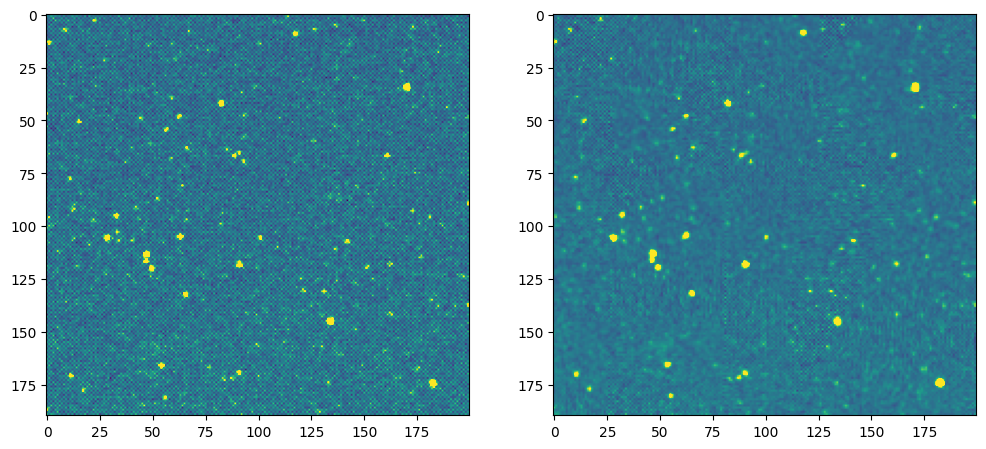

In [17]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice], vmin=500, vmax=1500)
# plt.imshow(imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(output_data[aslice], vmin=500, vmax=1500)

In [18]:
# the final step would be to co-add the drizzled array with the reference image.
coadded = reference_imarray + output_data

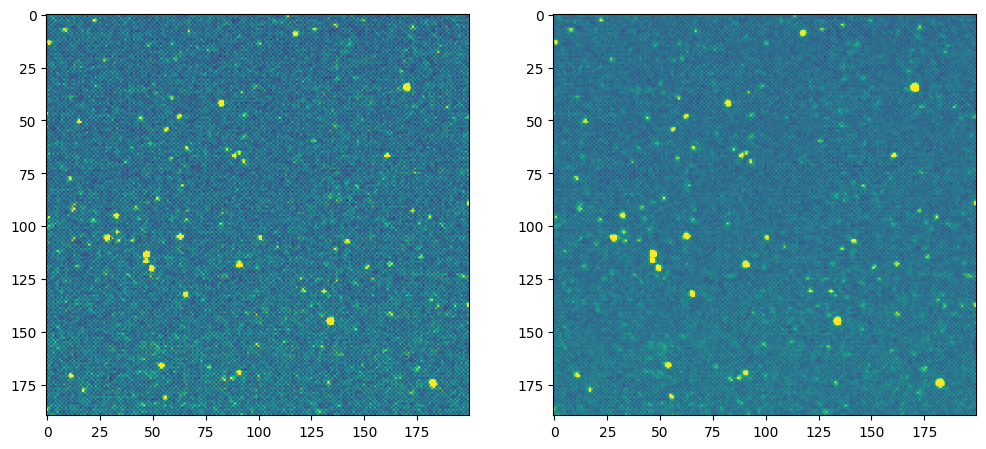

In [19]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(coadded[aslice], vmin=1000, vmax=3000)

In [20]:
print(np.mean(reference_imarray[aslice]), np.std(reference_imarray[aslice]))
print(np.mean(coadded[aslice]), np.std(coadded[aslice]))

900.1594736842105 254.81773814514403
1798.806971343994 396.9558661136662


## Drizzle and co-add a set of images

Lets run this over a set of images. Disregarding of course that they are Bayer RGB arrays and pretending they are just mono. 

We take the opportunity to capture the procedure outlined above, in a function that can be called multiple times.

In [21]:
def drizz(filename, output_array, weights, output_counts, output_context):
    # read input
    raw = rawpy.imread(filename)
    imarray = raw.raw_image_visible.astype(float)

    # read offsets
    fname_offsets = filename.replace('ARW', 'offsets.fits')
    f = fits.open(fname_offsets)
    offsets_x = f[1].data
    offsets_y = f[2].data
    f.close()
    
    # build 1-to-1 pixmap
    idxmap = np.indices((imarray.shape[1], imarray.shape[0]), dtype='float64')

    # add offsets
    idxmap[0] -= offsets_x.transpose()
    idxmap[1] -= offsets_y.transpose()

    # reshape for drizzle
    idxmap = idxmap.transpose()
    idxmap = idxmap.reshape(imarray.shape[1] * imarray.shape[0], 2)
    pixmap = idxmap.reshape(imarray.shape[0], imarray.shape[1], 2)

    # generate zeroed array and add the rawpy array to it.
    imarray_copy = np.zeros(imarray.shape, dtype='float32')
    imarray_copy += imarray
            
    # call C core drizzle algorithm
    cdrizzle.tdriz(imarray_copy, weights, pixmap, output_array, output_counts, output_context)

Now, loop over images and co-add them.

In [22]:
# list of image names to be processed
path = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')
list_p = glob.glob(path + '/*.ARW')
list_p.sort()

# arrays used by drizzle
weights = np.ones(imarray.shape, dtype='float32')
output_counts = np.zeros(imarray.shape, dtype='float32')
output_context = np.zeros(imarray.shape, dtype='int32')

# reference image; in this case is the first in list. This depends on how
# the Offsets_X scripts were configured!
fname = list_p[0]
raw = rawpy.imread(fname)
reference_imarray = raw.raw_image_visible.astype(float)

# the sum is made on top of the already existing reference image array
coadded = np.zeros(imarray.shape, dtype='float32')
coadded += reference_imarray

for fname in list_p[1:]:
    print(fname)
    output_array = np.zeros(imarray.shape, dtype='float32')

    drizz(fname, output_array, weights, output_counts, output_context)
    
    coadded += output_array

# average result
coadded /= len(list_p)    

/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03771.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03772.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03773.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03774.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03775.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03776.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03777.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03778.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW
/Volumes/PortableSSD/backup/Projects/astrophotography_data/MilkyWayPrettyBoy/12800

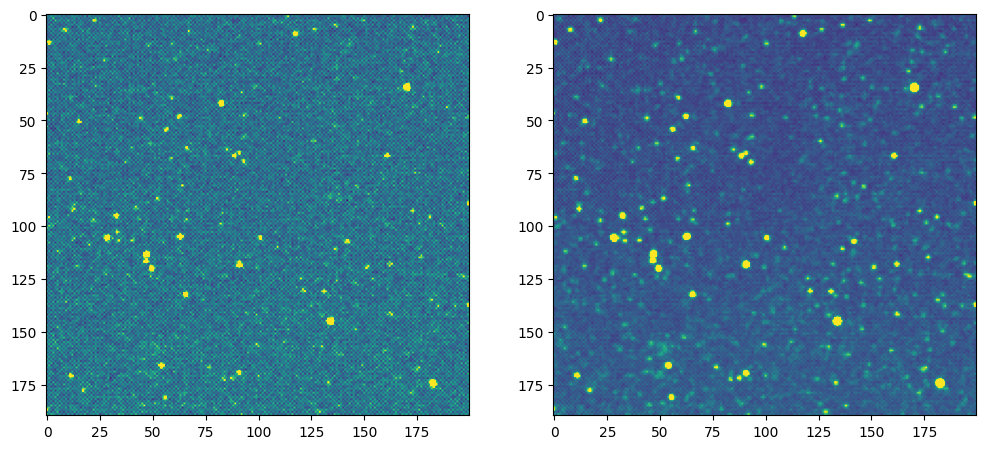

In [47]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice],  vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(coadded[aslice], vmin=70, vmax=120)

In [36]:
print(np.mean(coadded[aslice]), np.std(coadded[aslice]), np.min(coadded[aslice]))

84.938446 15.977943 74.833954
